<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/MODEL-COMPRESSION/blob/main/linear_quantization/quantizeAndDequantize_linearly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this notebook is just a simple implementation of linear quantization. just to get a sense of the proess

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

utility function for plotting the tensors

In [2]:
def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()

to have linear quantization with zero point and arbitrary scale

In [3]:
def linear_quantization(tensor, scale, zero_point, dtype= torch.int8):
  # we first need to scale and zero center the input tensor
  scaled_shifted_tensor = tensor / scale + zero_point
  #now round the output of previous step
  round_tensor = torch.round(scaled_shifted_tensor)
  #calculate the max and min of the dtype
  q_min = torch.iinfo(dtype).min
  q_max = torch.iinfo(dtype).max
  q_tensor = round_tensor.clamp(q_min, q_max).to(dtype)
  return q_tensor

now to test the linear quantization funtion

In [4]:
input_tensor = torch.randn((3, 3)) * 100

initiate the zero point and scale randomly

In [5]:
scale = 3.5
zero_point = -70

In [6]:
quantized_tensor = linear_quantization(
    input_tensor,
    scale,
    zero_point,
)
quantized_tensor

tensor([[ -47, -108,  -74],
        [ -20,  -70, -128],
        [ -24,  -91,  -68]], dtype=torch.int8)

now the dequantize process

In [7]:
def linear_dequantization(quantized_tensor, zero_point):
  return scale * (quantized_tensor.float() - zero_point)

In [8]:
dequantized_tensor = linear_dequantization(
    quantized_tensor,
    zero_point
)
dequantized_tensor

tensor([[  80.5000, -133.0000,  -14.0000],
        [ 175.0000,    0.0000, -203.0000],
        [ 161.0000,  -73.5000,    7.0000]])

In [9]:
dequantized_tensor, input_tensor

(tensor([[  80.5000, -133.0000,  -14.0000],
         [ 175.0000,    0.0000, -203.0000],
         [ 161.0000,  -73.5000,    7.0000]]),
 tensor([[  81.4230, -134.3775,  -13.7492],
         [ 175.9451,    0.2118, -209.0108],
         [ 162.4221,  -74.2045,    6.0794]]))

comparing the result of quantization

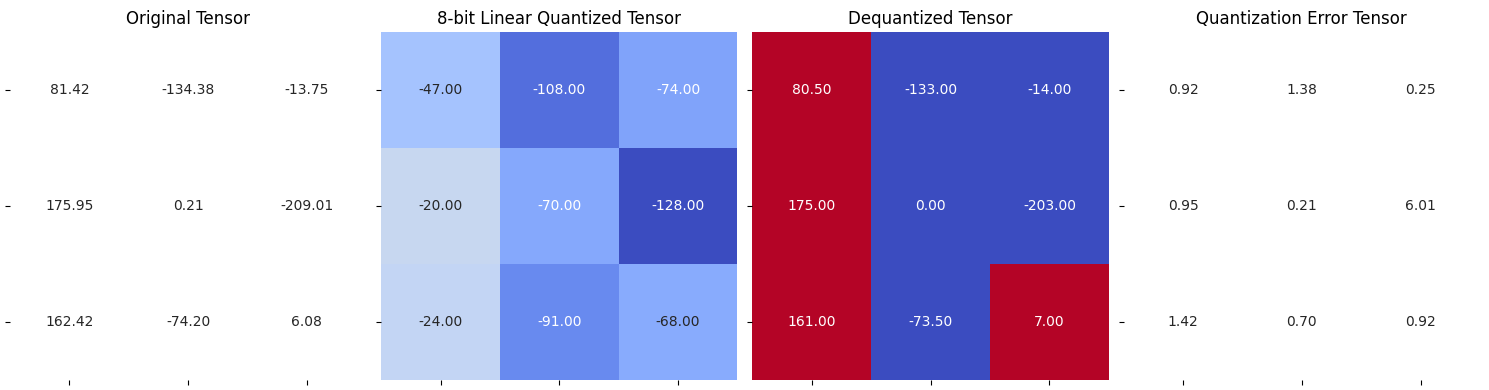

In [10]:
plot_quantization_errors(input_tensor,
                         quantized_tensor,
                         dequantized_tensor)

MSE calculation

In [11]:
(dequantized_tensor - input_tensor).square().mean()

tensor(4.8052)